## Identifying Fraudulent Activities
### Goal
E-commerce websites often transact huge amounts of money. And whenever a huge amount of
money is moved, there is a high risk of users performing fraudulent activities, e.g. using stolen
credit cards, doing money laundry, et􀁊.
Machine Learning really excels at identifying fraudulent activities. Any website where you put
your credit card information has a risk team in charge of avoiding frauds via machine learning.
The goal of this challenge is to build a machine learning model that predicts the probability that
the first transaction of a new user is fraudulent.
### Challenge Description
Company XYZ is an e-commerce site that sells hand-made clothes.
You have to build a model that predicts whether a user has a high probability of using the site to
perform some illegal activity or not. This is a super common task for data scientists.
You only have information about the user first transaction on the site and based on that you
have to make your classification ("fraud/no fraud").

These are the tasks you are asked to do:
1. Build a machine learning model that predicts the probability that the first transaction of a new user is fraudulent.
2. Describe what kinds of users are more likely to be classified as at risk? What are their characteristics?
3. From the product perspective, how can we use this model.


### Background
* The E-Commerce market is predicted to reach around $4.5 trillion in 2021.
* E-commerce businesses are the most vulnerable to online payment fraud as a physical card is not needed if you make a transaction online. Consequently, the number of fraud cases linked to online E-Commerce is rising. 
* Lloyd’s reports that fraud costs e-commerce merchants 7.6\% of their annual revenue and false positives cost them 2.8\% of revenue.


## 1. EDA

In [189]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.metrics import auc, roc_curve, roc_auc_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score, make_scorer, precision_recall_curve
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn import linear_model, preprocessing, tree, model_selection
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import cross_val_score, train_test_split, cross_val_predict, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, VotingClassifier, RandomForestRegressor, BaggingClassifier

In [2]:
sns.__version__

'0.11.1'

In [3]:
fraud_data = pd.read_csv("./Fraud_Data.csv")
Ip_to_country = pd.read_csv("./IpAddress_to_Country.csv")

In [4]:
fraud_data.info("")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         151112 non-null  int64  
 1   signup_time     151112 non-null  object 
 2   purchase_time   151112 non-null  object 
 3   purchase_value  151112 non-null  int64  
 4   device_id       151112 non-null  object 
 5   source          151112 non-null  object 
 6   browser         151112 non-null  object 
 7   sex             151112 non-null  object 
 8   age             151112 non-null  int64  
 9   ip_address      151112 non-null  float64
 10  class           151112 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 12.7+ MB


In [5]:
fraud_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [6]:
Ip_to_country.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [7]:
fraud_data[fraud_data.duplicated(keep=False) == True]

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class


In [8]:
Ip_to_country[Ip_to_country.duplicated(keep=False) == True]

,lower_bound_ip_address,upper_bound_ip_address,country


In [9]:
country = len(fraud_data) * [0]

for ind, row in fraud_data.iterrows():
    temp = Ip_to_country[(Ip_to_country['lower_bound_ip_address'] < row['ip_address']) & 
           (Ip_to_country['upper_bound_ip_address'] > row['ip_address'])]['country']
    
    if len(temp) == 1:
        country[ind] = temp.values[0]

fraud_data['country'] = country

In [11]:
fraud_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


Overall fraudulent activity rate: 0.09364577267192546


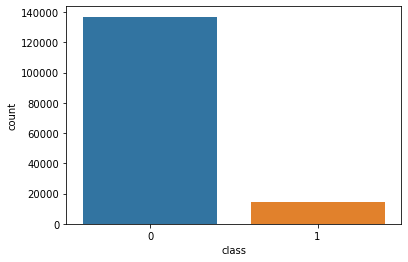

In [12]:
sns.countplot(x='class', data=fraud_data)
print('Overall fraudulent activity rate:', fraud_data[fraud_data['class']==1].shape[0]/fraud_data.shape[0] * 100)

In [13]:
fraud_data['class'].value_counts()

0    136961
1     14151
Name: class, dtype: int64

### This is an imbalanced class dataset, with the fraud class ratio of 9.3%.

In [14]:
fraud_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


In [15]:
fraud_data.describe()

,user_id,purchase_value,age,ip_address,class
count,151112.000000,151112.000000,151112.000000,1.511120e+05,151112.000000
mean,200171.040970,36.935372,33.140704,2.152145e+09,0.093646
std,115369.285024,18.322762,8.617733,1.248497e+09,0.291336
min,2.000000,9.000000,18.000000,5.209350e+04,0.000000
25%,100642.500000,22.000000,27.000000,1.085934e+09,0.000000
50%,199958.000000,35.000000,33.000000,2.154770e+09,0.000000
75%,300054.000000,49.000000,39.000000,3.243258e+09,0.000000
max,400000.000000,154.000000,76.000000,4.294850e+09,1.000000


In [16]:
fraud_data.select_dtypes(include='object').describe()

,signup_time,purchase_time,device_id,source,browser,sex,country
count,151112,151112,151112,151112,151112,151112,151112
unique,151112,150679,137956,3,5,2,182
top,2015-01-22 23:45:41,2015-07-17 23:22:55,ZUSVMDEZRBDTX,SEO,Chrome,M,United States
freq,1,3,20,60615,61432,88293,58049


### There are so many unique values in signup_time and purchase_time and device_id, we will need to apply some process on these features before use them:
1. calculate the time difference between the signup_time and purchase_time, in unit of days or in unit of hours (need to select one); create a new feature as hour of day for purchase time.
2. extract duplicated device/ip frequency as they might be useful features to detect suspicious activities.
3. There are 182 unique countries, we will need to test different encoding methods for it, calculate the fraud rate for each country as a new feature.
4. one-hot encoder for source, browser; binary encoder for sex.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000194867D1278>,
      dtype=object)

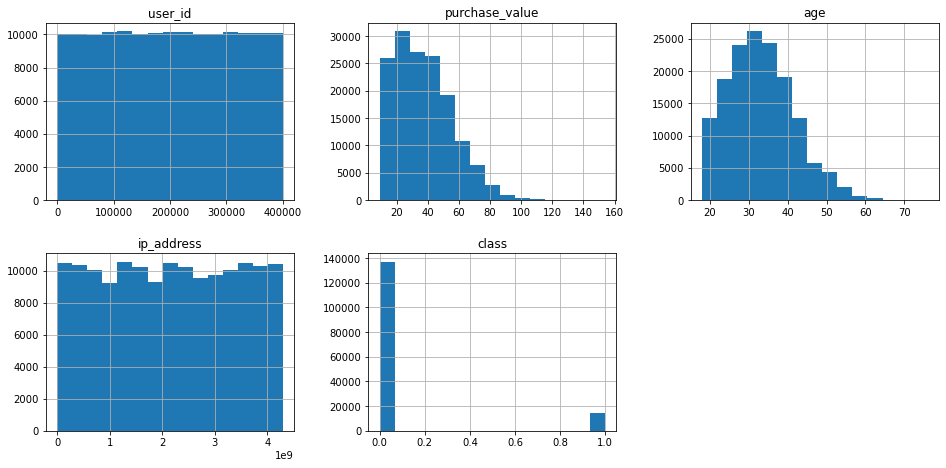

In [17]:
##check the distribution of different features:

fraud_data.hist(bins=15, figsize=(16,16), layout=(4,3))

## 2. Feature engineer 

### Based on the EDA, we transformed and created a few more features explained below:
1. Time difference (Purchase time – signup time): the amount of time between signing up new account and making purchase. Quick purchase: the time difference is less than 30s.

2. IP address frequency: the frequency of the same IP address has been used to signup new account and make purchase.

3. Device ID frequency: the frequency of the same device ID has been used to signup new account and make purchase.

4. Signup/Purchase time variants: the hour of the day, the day of the week, the month of the year, etc.

5. Regions with high fraud rate: calculate the fraud rate per country from the training data and divide the data into different groups.


In [78]:
FE_data = fraud_data.copy()

FE_data['signup_time'] = pd.to_datetime(FE_data['signup_time'])
FE_data['purchase_time'] = pd.to_datetime(FE_data['purchase_time'])
FE_data['timedif'] = FE_data['purchase_time'] - FE_data['signup_time']
FE_data['timedif_second'] = FE_data['timedif'].astype('timedelta64[s]')
FE_data['timedif_hour'] = FE_data['timedif'].astype('timedelta64[h]')
FE_data['purchase_hourofday'] = FE_data['purchase_time'].dt.hour
FE_data['purchase_dayofweek'] = FE_data['purchase_time'].dt.dayofweek
FE_data['purchase_month'] = FE_data['purchase_time'].dt.month

In [79]:
FE_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,timedif,timedif_second,timedif_hour,purchase_hourofday,purchase_dayofweek,purchase_month
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,52 days 03:51:22,4506682.0,1251.0,2,5,4
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,0 days 04:59:04,17944.0,4.0,1,0,6
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,0 days 00:00:01,1.0,0.0,18,3,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,0,5 days 16:41:25,492085.0,136.0,13,0,5
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,50 days 11:31:01,4361461.0,1211.0,18,2,9


In [80]:
temp = FE_data['device_id'].value_counts().reset_index()
temp.columns = ['device_id', 'device_freq']

temp.head()

,device_id,device_freq
0,ZUSVMDEZRBDTX,20
1,NGQCKIADMZORL,20
2,CQTUVBYIWWWBC,20
3,ITUMJCKWEYNDD,20
4,EQYVNEGOFLAWK,20


b:\program files\phthon\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


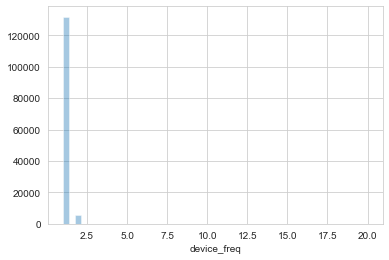

In [81]:
sns.distplot(temp.device_freq, kde=False)

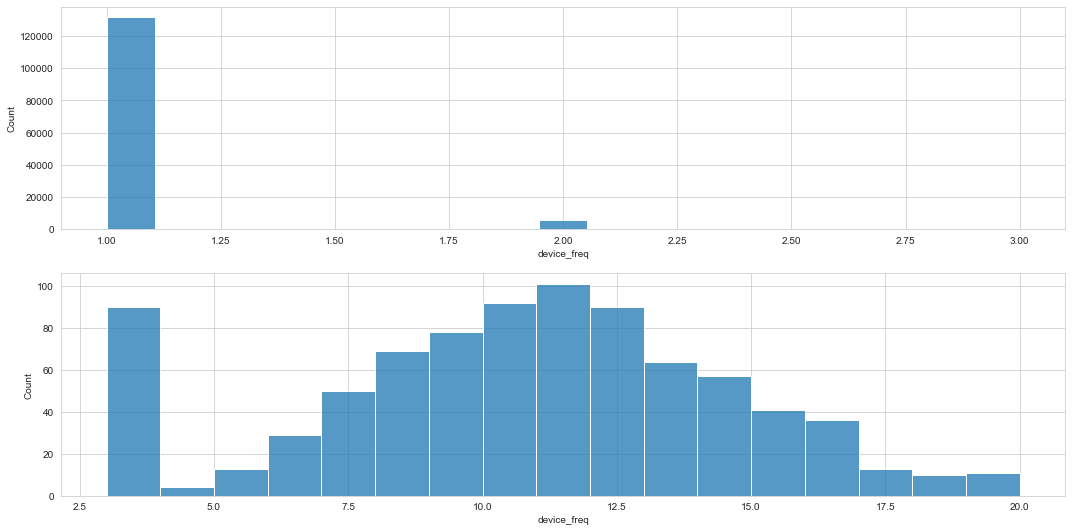

In [31]:
plt.figure(figsize=(18,9))
sns.set_style("whitegrid")
plt.subplot(2,1,1)
sns.histplot(temp.device_freq[temp.device_freq < 4])
plt.subplot(2,1,2)
sns.histplot(temp.device_freq[temp.device_freq > 2])

In [82]:
temp2 = FE_data['ip_address'].value_counts().reset_index()
temp2.columns = ['ip_address', 'ip_freq']

temp2['ip_freq'].value_counts()

1     142752
11       100
12        91
10        89
9         82
8         71
13        64
14        59
7         50
16        36
15        36
6         30
5         13
17        12
18         9
19         7
4          4
20         4
3          2
2          1
Name: ip_freq, dtype: int64

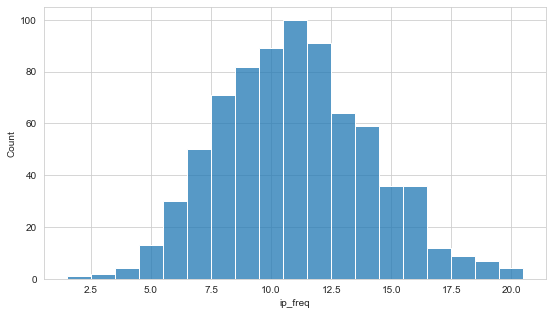

In [30]:
plt.figure(figsize=(9,5))
sns.set_style("whitegrid")
sns.histplot(temp2.ip_freq[temp2.ip_freq > 1], discrete=True)


In [70]:
temp3 = FE_data['user_id'].value_counts().reset_index()
temp3.columns = ['user_id', 'id_freq']

temp3['id_freq'].value_counts()

1    151112
Name: id_freq, dtype: int64

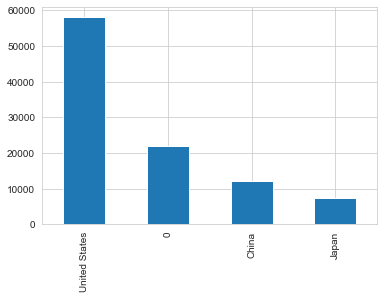

In [44]:
#Let's see the rank of countries with more than 5000 records:
FE_data.country.value_counts()[FE_data.country.value_counts() >5000].plot(kind="bar")

In [56]:
print(FE_data[(FE_data['country'] == 'India') & (FE_data['class'] == 1)].shape[0], FE_data[FE_data['country'] == 'India'].shape[0])

151 1310


In [60]:
temp4 = []
for each in FE_data['country'].unique():
    fd_ratio = FE_data[(FE_data['country'] == each) & (FE_data['class'] == 1)].shape[0]/FE_data[FE_data['country'] == each].shape[0]
    count = FE_data[FE_data['country'] == each].shape[0]
    print(each, fd_ratio, count)
    temp4.append([each, fd_ratio, count])

Japan 0.09786476868327403 7306
United States 0.09562610897689883 58049
0 0.08572339069471001 21966
Canada 0.11697478991596638 2975
China 0.08664229938527995 12038
Brazil 0.0911854103343465 2961
India 0.11526717557251909 1310
Argentina 0.09984871406959153 661
United Kingdom 0.10623608017817372 4490
South Africa 0.0883054892601432 838
Germany 0.0718595721338453 3646
Mexico 0.12845673505798394 1121
Sweden 0.12018348623853212 1090
Korea Republic of 0.0913022585295531 4162
Peru 0.2605042016806723 119
Portugal 0.043668122270742356 229
Bangladesh 0.08108108108108109 37
France 0.09490667510281557 3161
Taiwan; Republic of China (ROC) 0.08003233629749394 1237
Russian Federation 0.08292079207920793 1616
Belgium 0.13691931540342298 409
Denmark 0.15918367346938775 490
Netherlands 0.07321428571428572 1680
Iran (ISLAMIC Republic Of) 0.10796915167095116 389
Spain 0.07108081791626096 1027
Gabon 0.0 9
Saudi Arabia 0.1893939393939394 264
Hong Kong 0.12951167728237792 471
Georgia 0.0625 32
Syrian Arab Rep

In [61]:
temp4df = pd.DataFrame(data=temp4, columns = ['country', 'fraud_ratio', 'count'])
temp4df.sort_values(by=['fraud_ratio'], ascending=False)

,country,fraud_ratio,count
92,Turkmenistan,1.000000,1
81,Namibia,0.434783,23
119,Sri Lanka,0.419355,31
114,Luxembourg,0.388889,72
127,Virgin Islands (U.S.),0.333333,3
...,...,...,...
130,Uganda,0.000000,13
128,Congo,0.000000,3
126,South Sudan,0.000000,1
124,Bahrain,0.000000,14


### The fraud ratio per country has selection bias, so we cannot use it directly, we can consider to bin them into different categories.

In [73]:
temp4df["risk_country"] = temp4df["fraud_ratio"].apply(lambda x : 
                                                           "Very High risk" if x > 0.25 else
                                                           "High risk" if x > 0.05 else
                                                           "Medium risk" if x > 0.01 else
                                                           "Low risk")

In [83]:
FE2_data = pd.merge(FE_data, temp, how='outer', on='device_id')
FE2_data = pd.merge(FE2_data, temp2, how='outer', on='ip_address')
FE2_data = pd.merge(FE2_data, temp4df, how='outer', on='country')
FE2_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,...,timedif_second,timedif_hour,purchase_hourofday,purchase_dayofweek,purchase_month,device_freq,ip_freq,fraud_ratio,count,risk_country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,...,4506682.0,1251.0,2,5,4,1,1,0.097865,7306,High risk
1,243817,2015-02-13 18:16:05,2015-04-23 17:44:27,72,YIIEFBZUGEXNR,Direct,Chrome,F,32,2.521871e+09,...,5959702.0,1655.0,17,3,4,1,1,0.097865,7306,High risk
2,81113,2015-08-16 12:56:45,2015-08-24 05:00:54,52,BKQVBSSFGETUQ,Direct,Chrome,F,44,3.682312e+09,...,662649.0,184.0,5,0,8,1,1,0.097865,7306,High risk
3,103087,2015-01-04 13:22:11,2015-01-05 12:17:48,67,ZTORJKTDMYTJH,Direct,IE,F,49,3.665105e+09,...,82537.0,22.0,12,0,1,2,1,0.097865,7306,High risk
4,83866,2015-07-13 11:14:18,2015-09-20 08:18:30,33,JQYCFABXAMQVP,SEO,Chrome,F,34,7.359961e+08,...,5951052.0,1653.0,8,6,9,2,1,0.097865,7306,High risk


In [84]:
#apply binning to age, hourofday
FE2_data['age_bin'] = FE2_data['age'].apply(lambda x: 
                                             "< 20" if x < 20 else
                                             "20 - 29" if x < 30 else
                                             "30 -39" if x < 40 else
                                             "40 - 49" if x < 50 else
                                             "50 - 59" if x < 60 else
                                             " > 60")

FE2_data["period_of_the_day"] = FE2_data['purchase_hourofday'].apply(lambda x : 
                                                             "midnight" if x < 2 else
                                                             "early morning" if x < 5 else
                                                             "morning" if x < 8 else
                                                             "morning" if x < 12 else
                                                             "afternoon " if x < 18 else
                                                             "evening" if x < 22 else
                                                             "late night"
                                                            )

FE2_data["quick_purchase"] = FE2_data['timedif_second'].apply(lambda x : 1 if x < 30 else 0)


In [85]:
FE2_data['country'].replace(to_replace = 0, value = 'others', inplace=True)

In [86]:
dummy_source = pd.get_dummies(FE2_data, prefix=['source'], columns=['source'], drop_first=True)
dummy_source = pd.get_dummies(dummy_source, prefix=['browser'], columns=['browser'], drop_first=True)

le = LabelEncoder()
dummy_source['sex'] = le.fit_transform(FE2_data['sex'])

In [87]:
dummy_source

,user_id,signup_time,purchase_time,purchase_value,device_id,sex,age,ip_address,class,country,...,risk_country,age_bin,period_of_the_day,quick_purchase,source_Direct,source_SEO,browser_FireFox,browser_IE,browser_Opera,browser_Safari
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,1,39,7.327584e+08,0,Japan,...,High risk,30 -39,early morning,0,0,1,0,0,0,0
1,243817,2015-02-13 18:16:05,2015-04-23 17:44:27,72,YIIEFBZUGEXNR,0,32,2.521871e+09,0,Japan,...,High risk,30 -39,afternoon,0,1,0,0,0,0,0
2,81113,2015-08-16 12:56:45,2015-08-24 05:00:54,52,BKQVBSSFGETUQ,0,44,3.682312e+09,0,Japan,...,High risk,40 - 49,morning,0,1,0,0,0,0,0
3,103087,2015-01-04 13:22:11,2015-01-05 12:17:48,67,ZTORJKTDMYTJH,0,49,3.665105e+09,0,Japan,...,High risk,40 - 49,afternoon,0,1,0,0,1,0,0
4,83866,2015-07-13 11:14:18,2015-09-20 08:18:30,33,JQYCFABXAMQVP,0,34,7.359961e+08,0,Japan,...,High risk,30 -39,morning,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151107,40206,2015-02-19 20:21:17,2015-04-04 02:46:18,26,CIWJPLNHZBBDV,0,23,3.277722e+09,0,Yemen,...,Low risk,20 - 29,early morning,0,0,1,0,1,0,0
151108,369153,2015-01-26 19:36:24,2015-02-03 02:14:54,12,ALALTFKYSIFXH,1,34,1.505370e+09,0,San Marino,...,Low risk,30 -39,early morning,0,0,0,0,0,0,0
151109,209282,2015-03-27 22:02:49,2015-06-03 05:25:51,18,KUZBDYGURFVSN,0,24,3.314912e+09,0,Burundi,...,Low risk,20 - 29,morning,0,0,0,1,0,0,0
151110,193457,2015-05-02 15:27:48,2015-05-14 20:59:33,45,UZBDAROVIEOPM,1,30,3.412259e+09,0,Nauru,...,Low risk,30 -39,evening,0,0,1,1,0,0,0


## 3. Feature selection

In [94]:
FE3_data = dummy_source.drop(['signup_time', 'purchase_time', 'country', 'fraud_ratio', 'count', 'device_id', 'timedif', 'timedif_second', 'ip_address'], axis=1)
FE3_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151112 entries, 0 to 151111
Data columns (total 21 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   user_id             151112 non-null  int64  
 1   purchase_value      151112 non-null  int64  
 2   sex                 151112 non-null  int32  
 3   age                 151112 non-null  int64  
 4   class               151112 non-null  int64  
 5   timedif_hour        151112 non-null  float64
 6   purchase_hourofday  151112 non-null  int64  
 7   purchase_dayofweek  151112 non-null  int64  
 8   purchase_month      151112 non-null  int64  
 9   device_freq         151112 non-null  int64  
 10  ip_freq             151112 non-null  int64  
 11  risk_country        151112 non-null  object 
 12  age_bin             151112 non-null  object 
 13  period_of_the_day   151112 non-null  object 
 14  quick_purchase      151112 non-null  int64  
 15  source_Direct       151112 non-nul

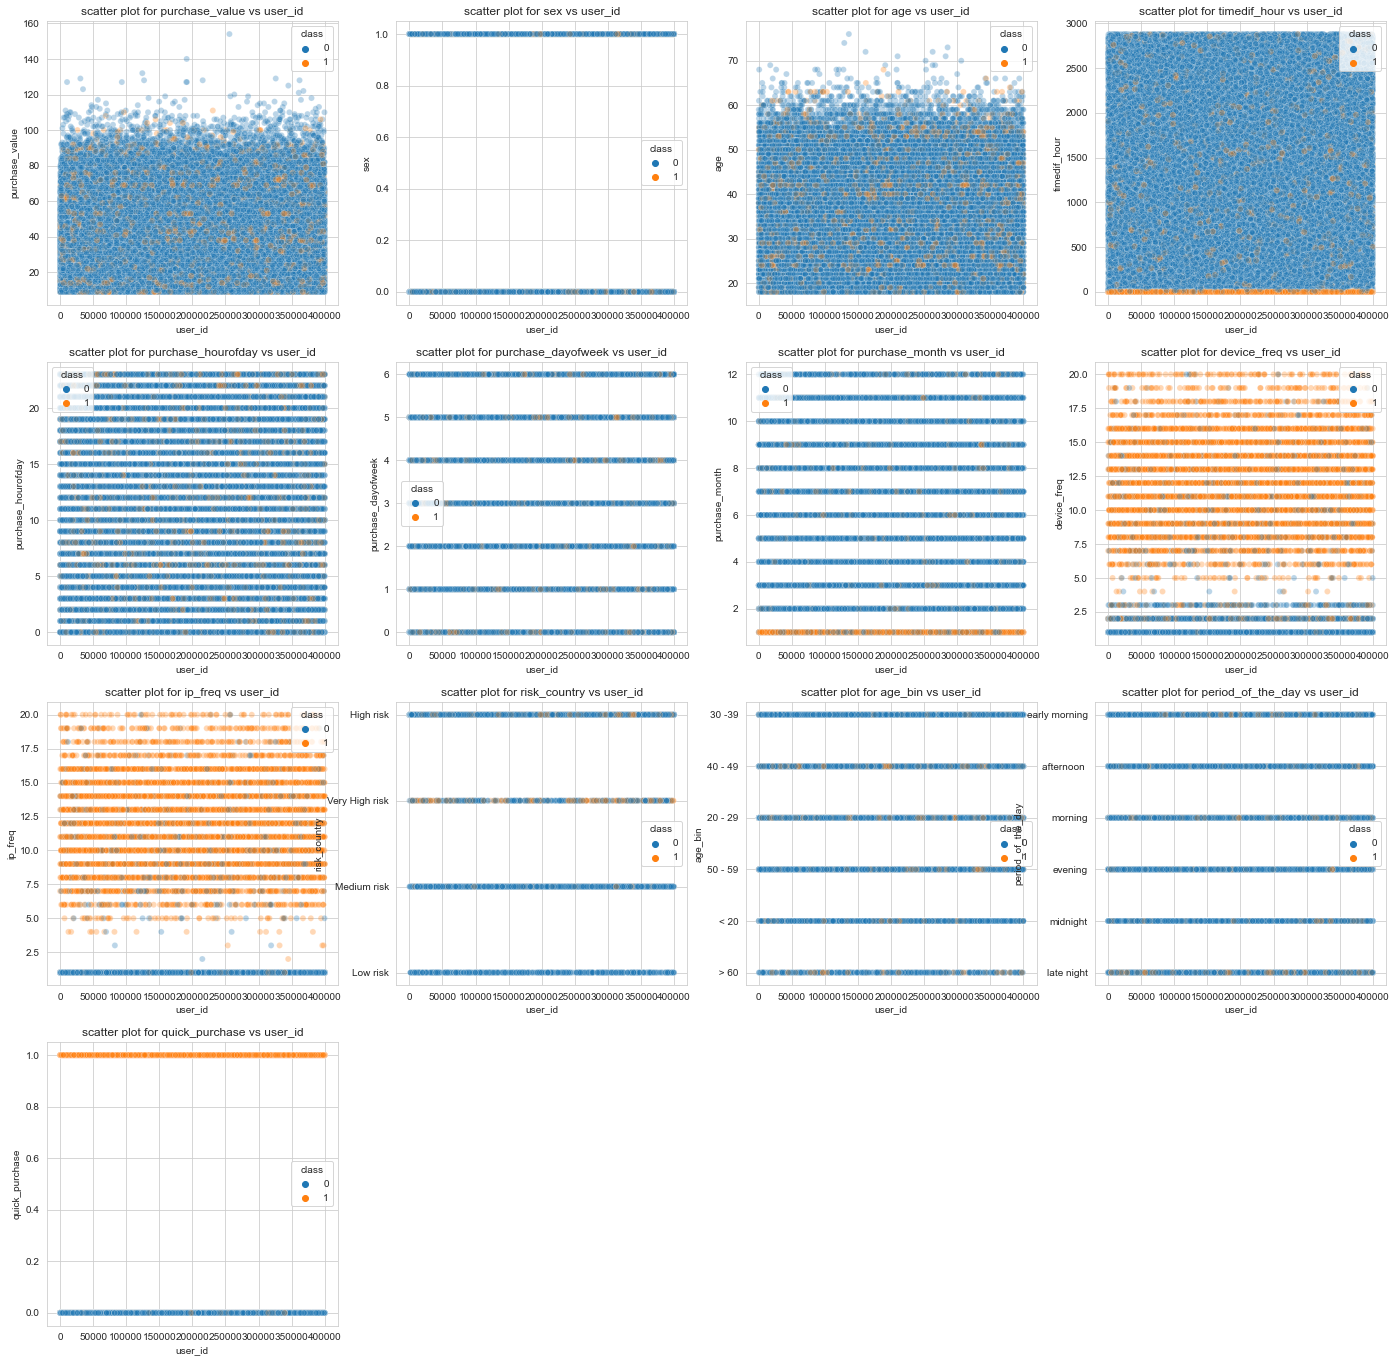

In [95]:
allmetrics = FE3_data.drop(['class', 'user_id'],axis=1)
allmetrics = allmetrics.select_dtypes(exclude='uint8').columns
plt.figure(figsize=(24,24))
n = 1
for each in allmetrics:
    plt.subplot(4,4,n)
    sns.scatterplot(x='user_id', y=each, hue='class', data=FE3_data, alpha=0.3)
    plt.title('scatter plot for {} vs user_id'.format(each))
    n += 1

Text(0.5, 1.0, 'scatter plot for source_Direct vs user_id')

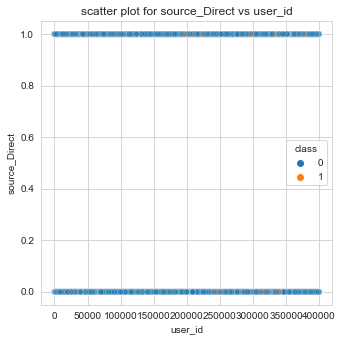

In [227]:
plt.figure(figsize=(24,24))
plt.subplot(4,4,1)
sns.scatterplot(x='user_id', y='source_Direct', hue='class', data=FE3_data, alpha=0.3)
plt.title('scatter plot for {} vs user_id'.format('source_Direct'))

In [99]:
le = LabelEncoder()
FE3_data['risk_country'] = le.fit_transform(FE3_data['risk_country'])
FE3_data['age_bin'] = le.fit_transform(FE3_data['age_bin'])
FE3_data['period_of_the_day'] = le.fit_transform(FE3_data['period_of_the_day'])


In [123]:
FE3_data

,user_id,purchase_value,sex,age,class,timedif_hour,purchase_hourofday,purchase_dayofweek,purchase_month,device_freq,...,risk_country,age_bin,period_of_the_day,quick_purchase,source_Direct,source_SEO,browser_FireFox,browser_IE,browser_Opera,browser_Safari
0,22058,34,1,39,0,1251.0,2,5,4,1,...,0,2,1,0,0,1,0,0,0,0
1,243817,72,0,32,0,1655.0,17,3,4,1,...,0,2,0,0,1,0,0,0,0,0
2,81113,52,0,44,0,184.0,5,0,8,1,...,0,3,5,0,1,0,0,0,0,0
3,103087,67,0,49,0,22.0,12,0,1,2,...,0,3,0,0,1,0,0,1,0,0
4,83866,33,0,34,0,1653.0,8,6,9,2,...,0,2,5,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151107,40206,26,0,23,0,1038.0,2,5,4,1,...,1,1,1,0,0,1,0,1,0,0
151108,369153,12,1,34,0,174.0,2,1,2,1,...,1,2,1,0,0,0,0,0,0,0
151109,209282,18,0,24,0,1615.0,5,2,6,1,...,1,1,5,0,0,0,1,0,0,0
151110,193457,45,1,30,0,293.0,20,3,5,1,...,1,2,2,0,0,1,1,0,0,0


### From this scatter plot, it's obvious to spot the correlation between the device_frequency and the fraudulent activities.

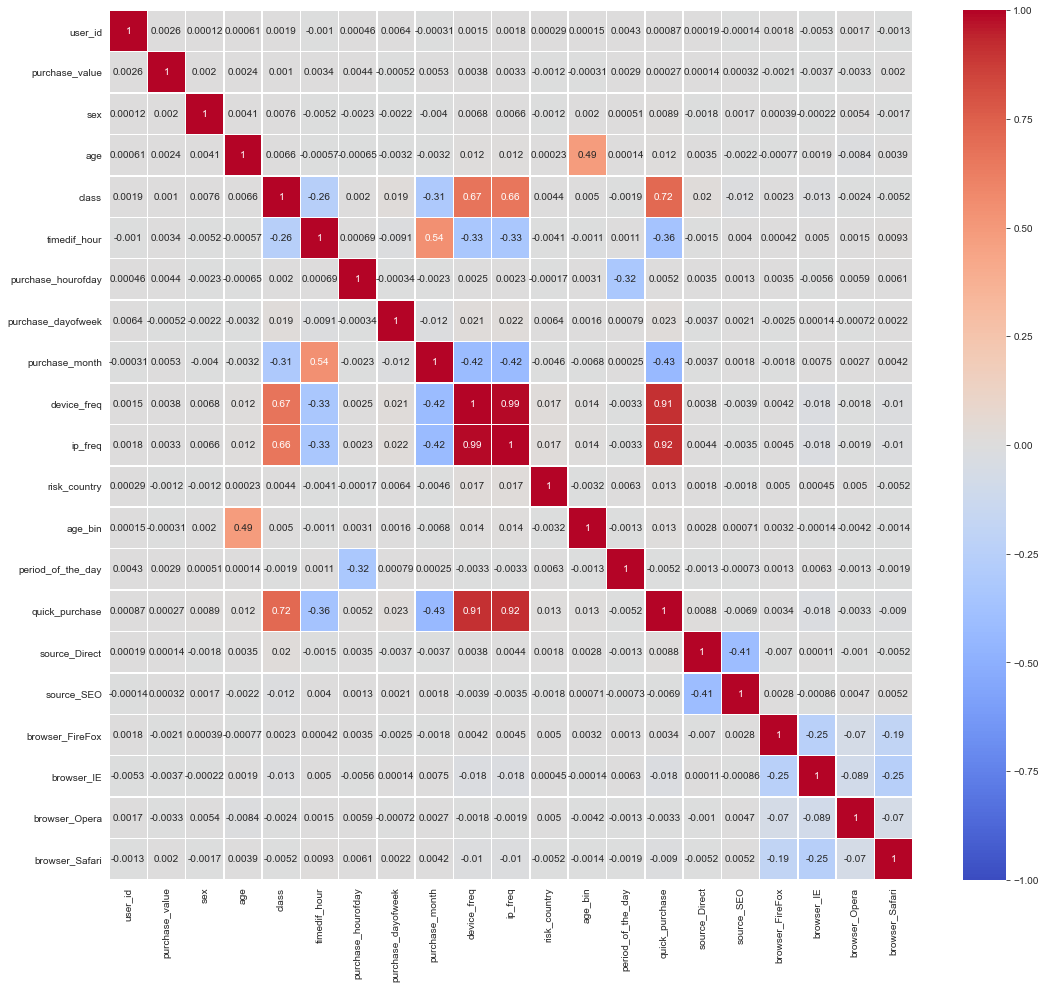

In [100]:
#What's the correlation between these variables? 1. primitive feature selection using pearson's correlation
corr = FE3_data.corr()
plt.figure(figsize=(18,16))
sns.heatmap(corr, cmap='coolwarm', linewidth=.5, annot=True, vmin=-1, vmax=1)

In [107]:
##feature selection, remove duplicated feature when keeping their new variant.
FE3s_data = FE3_data.drop(['age', 'user_id', 'timedif_hour', 'purchase_hourofday', ], axis=1)


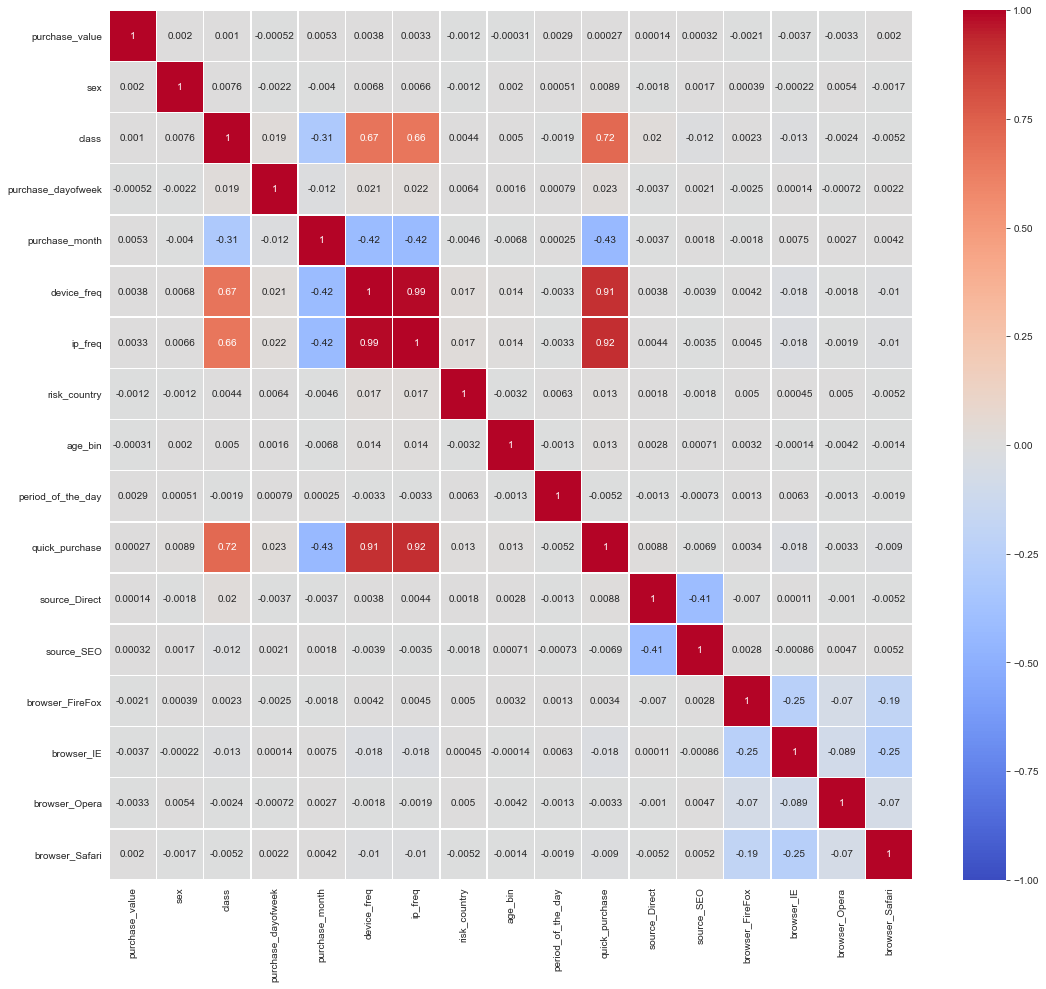

In [111]:
corr = FE3s_data.corr()
plt.figure(figsize=(18,16))
sns.heatmap(corr, cmap='coolwarm', linewidth=.5, annot=True, vmin=-1, vmax=1)

In [118]:
##feature selection manually remove the colinear features to avoid multicollinearity
FE3s2_data = FE3s_data.drop(['ip_freq', 'device_freq'], axis=1)


### Feature engineering summary
The feature importance rank based on the correlation to the dependent variable matches the observations in scatter plots:

* Quick_purchase
* Device_frequency
* Ip_frequency
* Purchase_month
* Time_difference_hour

The heat map also reveals some multi-collinearity among these features. We will test to address in the feature selection part.


#### The heat map is also showing similar conclusion that the device_freq is closely correlated to the class, the timediff_hour also seem to be related.

In [124]:
##train test data split with stratified splitting
FE3_X = FE3s_data.drop(['class'], axis=1)
FE3_y = FE3s_data['class']

X_train, X_test, y_train, y_test = train_test_split(FE3_X, FE3_y, train_size=0.8, random_state=42, stratify=FE3_y)


In [126]:
##Lasso regression feature selection

from sklearn.linear_model import LassoCV
reg = LassoCV()
reg.fit(X_train, y_train)
print('Best alpha using built-in LassoCV: %f' %reg.alpha_)
print('Best score using built-in LassoCV: %f' %reg.score(X_train, y_train))
coef = pd.Series(reg.coef_, index = X_train.columns)

Best alpha using built-in LassoCV: 0.000512
Best score using built-in LassoCV: 0.531926


In [127]:
print('lasso picked' +str(sum(coef != 0)) + 'variables and elimited the other' + str(sum(coef == 0)) + 'variables')

lasso picked8variables and elimited the other8variables


In [129]:
imp_coef = coef.sort_values()
imp_coef

ip_freq              -1.004408e-01
age_bin              -1.075695e-03
purchase_month       -8.792968e-05
sex                   0.000000e+00
risk_country         -0.000000e+00
period_of_the_day    -0.000000e+00
source_SEO           -0.000000e+00
browser_FireFox      -0.000000e+00
browser_IE           -0.000000e+00
browser_Opera        -0.000000e+00
browser_Safari        0.000000e+00
purchase_value        5.116454e-07
purchase_dayofweek    8.311287e-05
source_Direct         8.581832e-03
device_freq           1.063630e-01
quick_purchase        8.801254e-01
dtype: float64

In [152]:
imp_coef2 = imp_coef[imp_coef != 0]
imp_coef2

ip_freq              -1.004408e-01
age_bin              -1.075695e-03
purchase_month       -8.792968e-05
purchase_value        5.116454e-07
purchase_dayofweek    8.311287e-05
source_Direct         8.581832e-03
device_freq           1.063630e-01
quick_purchase        8.801254e-01
dtype: float64

In [160]:
FE4_X = FE3s_data[imp_coef2.index.values]
FE4_y = FE3s_data['class']

X2_train, X2_test, y2_train, y2_test = train_test_split(FE4_X, FE4_y, train_size=0.8, random_state=42, stratify=FE4_y)

In [97]:
y_train.value_counts()

0    109568
1     11321
Name: class, dtype: int64

In [116]:
##test resampling by SMOTE
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

smt = SMOTE(random_state = 42)
X_train_smt, y_train_smt = smt.fit_sample(X_train, y_train)
y_train_smt.value_counts()


1    109568
0    109568
Name: class, dtype: int64

In [161]:
from sklearn.feature_selection import RFE
model = linear_model.LogisticRegression(random_state=42)
rfe = RFE(model, 8)
X_rfe = rfe.fit_transform(X_train, y_train)
print(rfe.support_)
print(rfe.ranking_)

b:\program files\phthon\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=8 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
b:\program files\phthon\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
b:\program files\phthon\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale t

[False False False False  True  True  True  True False  True  True False
 False  True  True False]
[9 4 5 6 1 1 1 1 8 1 1 7 2 1 1 3]


In [158]:
rfe_select = pd.Series(rfe.support_, index = X_train.columns)
selected = rfe_select[rfe_select == True].index.values
print(selected)

['device_freq' 'ip_freq' 'risk_country' 'age_bin' 'quick_purchase'
 'source_Direct' 'browser_IE' 'browser_Opera']


In [165]:
FE5_X = FE3s_data[selected]
FE5_y = FE3s_data['class']

X3_train, X3_test, y3_train, y3_test = train_test_split(FE5_X, FE5_y, train_size=0.8, random_state=42, stratify=FE5_y)

### Two methods are tested to solve the Imbalanced class problem:
1. SMOTE + RUD(RandomUnderSampler)
2. Class weight

### Three methods of feature selection are tested:
1. Filter method: Pearson correlation (selected 16 features)
                             Pearson correlation to remove colinear features (selected 14 features)
2. Wrapper method: Recursive feature elimination (selected 8 features)
3. Embedded method: Lasso regression (selected 8 features)

### The ROC-AUC from validation/test set is compared here

|              | Baseline | Pearson correlation | Pearson corr. remove multi-collinearity | REA   | Lasso regression |
|--------------|----------|---------------------|-----------------------------------------|-------|------------------|
| SMOTE+RUD    | 0.746    | 0.811               | 0.781                                   | 0.835 | 0.838            |
| Class weight | 0.759    | 0.842               | 0.796                                   | 0.836 | 0.835            |

### The following treatment was chosen to select the feature for modeling:
Peason correlation to select 16 features, applied class weight option to balance the weight.

## Modeling

In [166]:
##baseline model with logistic regression.

lr = linear_model.LogisticRegression(random_state=42)
lr_clf = lr.fit(X3_train, y3_train)
cv_score = model_selection.cross_val_score(lr_clf, X3_train, y3_train, scoring='roc_auc', cv=5)
print('logistic regression cv avg score:', cv_score.mean())

logistic regression cv avg score: 0.8488472743389475


In [167]:
lr = linear_model.LogisticRegression(random_state=42, class_weight='balanced')
lr_clf = lr.fit(X3_train, y3_train)
cv_score = model_selection.cross_val_score(lr_clf, X3_train, y3_train, scoring='roc_auc', cv=5)
print('logistic regression cv avg score:', cv_score.mean())

logistic regression cv avg score: 0.8488765886531848


In [ ]:
###v1 features:
LR roc_auc:0.796/0.841
###v2 features:
LR roc_auc:0.769/0.795
###v3 features:(removed duplicates)
LR roc_auc:0.846/0.845
###v3 features:(removed duplicates2)
LR roc_auc:0.780/0.780
##feature selection from Lasso
LR roc_auc:0.848/0.849
##feature selection from RFE
LR roc_auc:0.849/0.849


In [168]:
y_pred = lr_clf.predict(X3_test)
print('The confusion matrix for logistic regression is:\n', confusion_matrix(y_true=y3_test, y_pred=y_pred, labels=[1, 0]))
print(classification_report(y_true=y3_test, y_pred=y_pred, labels=[1, 0], digits=4))

The confusion matrix for logistic regression is:
 [[ 1995   835]
 [ 1726 25667]]
              precision    recall  f1-score   support

           1     0.5361    0.7049    0.6091      2830
           0     0.9685    0.9370    0.9525     27393

    accuracy                         0.9153     30223
   macro avg     0.7523    0.8210    0.7808     30223
weighted avg     0.9280    0.9153    0.9203     30223



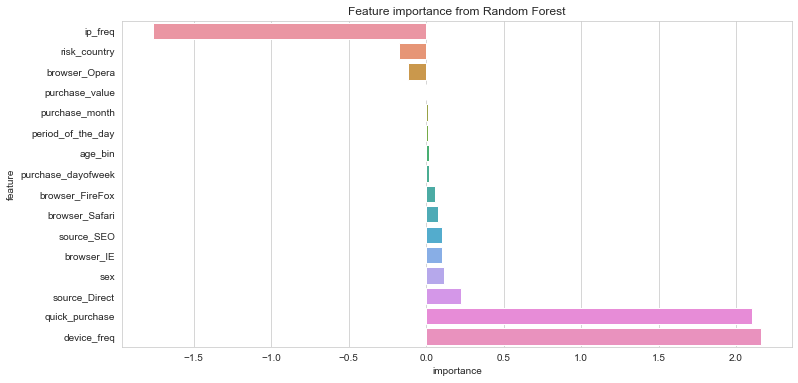

In [113]:
#print the feature importance
features = pd.DataFrame()
features['feature'] = X_train.columns
features['importance'] = lr_clf.coef_[0]
features.sort_values(by='importance').tail(10)

fig = plt.figure(figsize=(12,6))
sns.barplot(x=features['importance'], y=features['feature'], order=features.sort_values('importance').feature)
plt.title('Feature importance from Random Forest')
plt.show()

In [169]:
##random forest 

rfclf = RandomForestClassifier(random_state=42, class_weight='balanced')
rf = rfclf.fit(X3_train, y3_train)
cv_score = model_selection.cross_val_score(rfclf, X3_train, y3_train, scoring='roc_auc', cv=5)
print('random forest cv avg score:', cv_score.mean())

random forest cv avg score: 0.8466078674656737


In [171]:
y_pred2 = rfclf.predict(X3_test)
print('The confusion matrix for random forest is:\n', confusion_matrix(y_true=y3_test, y_pred=y_pred2, labels=[1, 0]))
print(classification_report(y_true=y3_test, y_pred=y_pred2, labels=[1, 0], digits=4))

The confusion matrix for random forest is:
 [[ 1985   845]
 [ 1700 25693]]
              precision    recall  f1-score   support

           1     0.5387    0.7014    0.6094      2830
           0     0.9682    0.9379    0.9528     27393

    accuracy                         0.9158     30223
   macro avg     0.7534    0.8197    0.7811     30223
weighted avg     0.9279    0.9158    0.9207     30223



In [172]:
##random forest 

rfclf = RandomForestClassifier(random_state=42, class_weight='balanced')
rf = rfclf.fit(X_train, y_train)
cv_score = model_selection.cross_val_score(rfclf, X_train, y_train, scoring='roc_auc', cv=5)
print('random forest cv avg score:', cv_score.mean())

random forest cv avg score: 0.8413018199278934


In [173]:
y_pred2 = rfclf.predict(X_test)
print('The confusion matrix for random forest is:\n', confusion_matrix(y_true=y_test, y_pred=y_pred2, labels=[1, 0]))
print(classification_report(y_true=y_test, y_pred=y_pred2, labels=[1, 0], digits=4))

The confusion matrix for random forest is:
 [[ 1532  1298]
 [  119 27274]]
              precision    recall  f1-score   support

           1     0.9279    0.5413    0.6838      2830
           0     0.9546    0.9957    0.9747     27393

    accuracy                         0.9531     30223
   macro avg     0.9412    0.7685    0.8292     30223
weighted avg     0.9521    0.9531    0.9474     30223



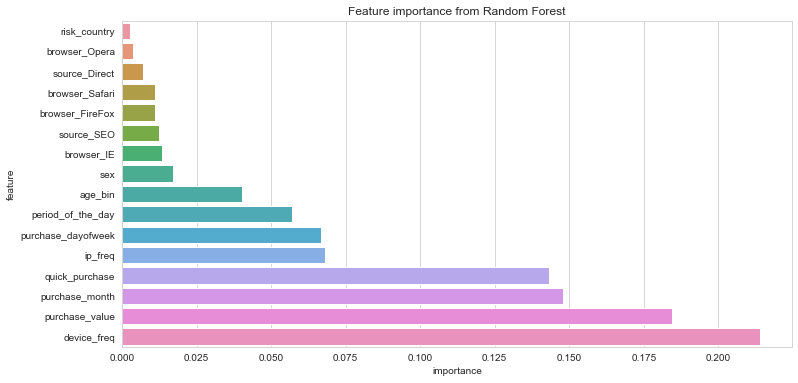

In [174]:
#print the feature importance
features = pd.DataFrame()
features['feature'] = X_train.columns
features['importance'] = rfclf.feature_importances_
features.sort_values(by='importance').tail(10)

fig = plt.figure(figsize=(12,6))
sns.barplot(x=features['importance'], y=features['feature'], order=features.sort_values('importance').feature)
plt.title('Feature importance from Random Forest')
plt.show()

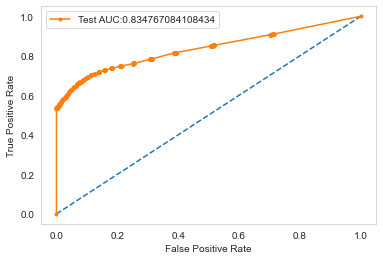

AUC for the model is: 0.834767084108434


In [175]:
y_scores = rfclf.predict_proba(X_test)
y_scores = y_scores[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
rocauc = roc_auc_score(y_test, y_scores)
plt.plot([0,1],[0,1], linestyle='--')
plt.plot(fpr,tpr,marker='.', label='Test AUC:' + str(rocauc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.show()
print('AUC for the model is:',rocauc)

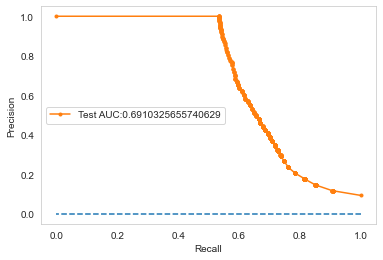

AUC for the model is: 0.6910325655740629


In [177]:
y_scores = rfclf.predict_proba(X_test)
y_scores = y_scores[:, 1]
prec, recall, thresholds = precision_recall_curve(y_test, y_scores)
pr_auc = auc(recall, prec)
plt.plot([1,0],[0,0], linestyle='--')
plt.plot(recall, prec, marker='.', label='Test AUC:' + str(pr_auc) )
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.legend()
plt.show()
print('AUC for the model is:',pr_auc)

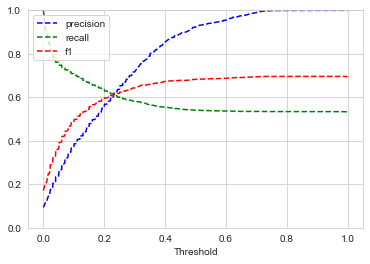

In [178]:
def plot_prec_recall_thre(precisions, recalls, thresholds):
    f1_ = 2*recalls*precisions/(recalls+precisions)
    plt.plot(thresholds, precisions[:-1], 'b--', label = 'precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label = 'recall')
    plt.plot(thresholds, f1_[:-1], 'r--', label = 'f1')
    plt.xlabel('Threshold')
    plt.legend(loc='upper left')
    plt.ylim([0,1])

plot_prec_recall_thre(prec, recall, thresholds)
plt.show()

In [222]:
##XGBOOST
import xgboost as xgb

xgboost = xgb.XGBClassifier(random_state=42, class_weight='balanced')
xgb_fit = xgboost.fit(X_train, y_train, eval_metric='auc', verbose=True)
cv_score = cross_val_score(xgboost, X_train, y_train, scoring='roc_auc', cv=5).mean()
print('the mean score of 5 cv sets for XGBOOST is:',cv_score)

y_pred3 = xgboost.predict(X_test)
print('The confusion matrix for XGBOOST is:\n', confusion_matrix(y_true=y_test, y_pred=y_pred3, labels=[1, 0]))
print(classification_report(y_true=y_test, y_pred=y_pred3, labels=[1, 0], digits=4))

[11:02:49] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:02:53] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:02:57] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in la

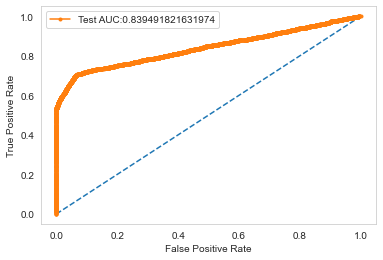

AUC for the model is: 0.839491821631974


In [223]:
y_scores = xgboost.predict_proba(X_test)
y_scores = y_scores[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
rocauc = roc_auc_score(y_test, y_scores)
plt.plot([0,1],[0,1], linestyle='--')
plt.plot(fpr,tpr,marker='.', label='Test AUC:' + str(rocauc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.show()
print('AUC for the model is:',rocauc)

In [185]:
#define a grid for Hyperopt to find the optimum hyperparamerters.
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

space = {'n_estimators': hp.quniform('n_estimators', 300, 4000, 100),
         'gamma' : hp.uniform('gamma', 0.01, 0.1),
         'learning_rate': hp.uniform('learning_rate', 0.0001, 0.05),
         'max_depth': hp.quniform('max_depth', 3, 15, 1),
         'subsample': hp.uniform('subsample', 0.3, 1),
         'reg_lambda': hp.uniform('reg_lambda', 1, 20)
        }

def Xgbtuning(space):
    
    reg = xgb.XGBClassifier(n_estimators=int(space['n_estimators']), max_depth=int(space['max_depth']), gamma=space['gamma'], learning_rate=space['learning_rate'], reg_lambda=space['reg_lambda'], subsample=space['subsample'])
    ##reg.fit(features, target, eval_set=evaluation, eval_metric="rmse",early_stopping_rounds=10,verbose=False)  need training/test set to evaluate the early stopping, since we are using hyperopt to evaluate the hyperparamerters
    #reg.fit(features, target)
    cvscore = model_selection.cross_val_score(reg, X_train, y_train, scoring='roc_auc', cv=5, n_jobs=-1).mean()
    #print(cvscore)
    return -cvscore
#Xgbtuning(space)

best = fmin(fn=Xgbtuning, space=space, max_evals=20, rstate=np.random.RandomState(42), algo=tpe.suggest, trials=Trials())
print(best)

100%|██████████| 20/20 [3:29:22<00:00, 628.13s/trial, best loss: -0.8482817689748032]  
{'gamma': 0.01044740700280588, 'learning_rate': 0.0015413378000615882, 'max_depth': 12.0, 'n_estimators': 1700.0, 'reg_lambda': 13.16019002990647, 'subsample': 0.7083584999492802}


In [187]:
##XGBoost after tunning

xgboost = xgb.XGBClassifier(gamma=0.0104, learning_rate=0.0015, max_depth=12, n_estimators=1700, reg_lambda=13.16, subsample=0.7084, random_state=42, class_weight='balanced')
xgb_fit = xgboost.fit(X_train, y_train, eval_metric='auc', verbose=True)
cv_score = cross_val_score(xgboost, X_train, y_train, scoring='roc_auc', cv=5).mean()
print('the mean score of 5 cv sets for XGBOOST is:',cv_score)

y_pred3 = xgboost.predict(X_test)
print('The confusion matrix for XGBOOST is:\n', confusion_matrix(y_true=y_test, y_pred=y_pred3, labels=[1, 0]))
print(classification_report(y_true=y_test, y_pred=y_pred3, labels=[1, 0], digits=4))



[22:00:39] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:02:26] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:03:50] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in la

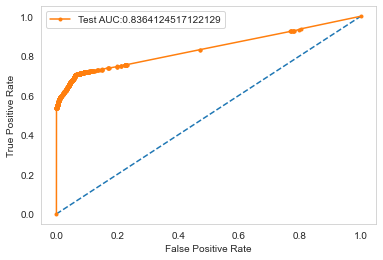

AUC for the model is: 0.8364124517122129


In [220]:
y_scores = xgboost.predict_proba(X_test)
y_scores = y_scores[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
rocauc = roc_auc_score(y_test, y_scores)
plt.plot([0,1],[0,1], linestyle='--')
plt.plot(fpr,tpr,marker='.', label='Test AUC:' + str(rocauc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.show()
print('AUC for the model is:',rocauc)

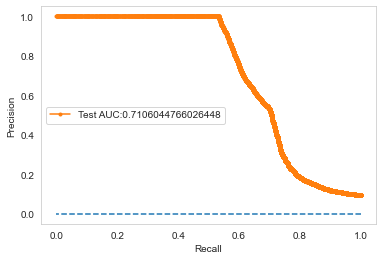

AUC for the model is: 0.7106044766026448


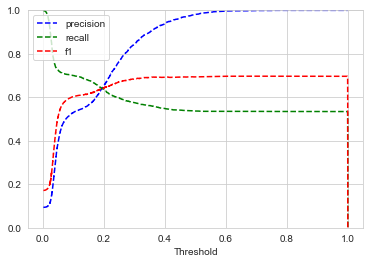

In [228]:
y_scores = xgboost.predict_proba(X_test)
y_scores = y_scores[:, 1]
prec, recall, thresholds = precision_recall_curve(y_test, y_scores)
pr_auc = auc(recall, prec)
plt.plot([1,0],[0,0], linestyle='--')
plt.plot(recall, prec, marker='.', label='Test AUC:' + str(pr_auc) )
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.legend()
plt.show()
print('AUC for the model is:',pr_auc)

def plot_prec_recall_thre(precisions, recalls, thresholds):
    f1_ = 2*recalls*precisions/(recalls+precisions)
    plt.plot(thresholds, precisions[:-1], 'b--', label = 'precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label = 'recall')
    plt.plot(thresholds, f1_[:-1], 'r--', label = 'f1')
    plt.xlabel('Threshold')
    plt.legend(loc='upper left')
    plt.ylim([0,1])

plot_prec_recall_thre(prec, recall, thresholds)
plt.show()

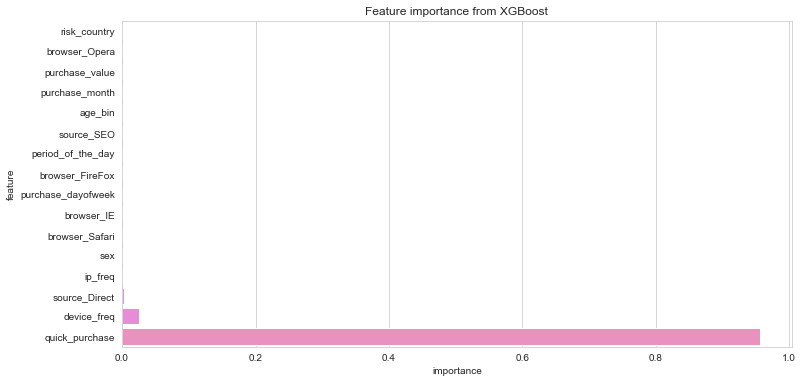

In [224]:
#print the feature importance
features = pd.DataFrame()
features['feature'] = X_train.columns
features['importance'] = xgboost.feature_importances_
features.sort_values(by='importance').tail(10)

fig = plt.figure(figsize=(12,6))
sns.barplot(x=features['importance'], y=features['feature'], order=features.sort_values('importance').feature)
plt.title('Feature importance from XGBoost')
plt.show()

In [190]:
#define a grid for RandomizedSearchCV to find the optimum hyperparamerters.
n_estimators = [int(x) for x in np.linspace(50, 1500, 20)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(5, 100, 10)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
class_weight = ['balanced']

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'class_weight': class_weight}

rf = RandomForestClassifier(random_state=42)
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, cv=3, scoring='roc_auc', verbose=2, random_state=42, n_jobs=-1)
rf_random.fit(X_train, y_train)    
print(rf_random.best_params_, rf_random.best_score_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 36.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 70.7min finished


{'n_estimators': 355, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 5, 'class_weight': 'balanced'} 0.8469212661752549


In [191]:
##random forest after tunning
rfclft = RandomForestClassifier(n_estimators=355, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', max_depth=5, random_state=42, class_weight='balanced')
rf = rfclft.fit(X_train, y_train)
cv_score = model_selection.cross_val_score(rfclft, X_train, y_train, scoring='roc_auc', cv=5)
print('random forest cv avg score:', cv_score.mean())

random forest cv avg score: 0.8486675926076179


In [192]:
y_pred2t = rfclft.predict(X_test)
print('The confusion matrix for random forest is:\n', confusion_matrix(y_true=y_test, y_pred=y_pred2t, labels=[1, 0]))
print(classification_report(y_true=y_test, y_pred=y_pred2t, labels=[1, 0], digits=4))

The confusion matrix for random forest is:
 [[ 1996   834]
 [ 1743 25650]]
              precision    recall  f1-score   support

           1     0.5338    0.7053    0.6077      2830
           0     0.9685    0.9364    0.9522     27393

    accuracy                         0.9147     30223
   macro avg     0.7512    0.8208    0.7799     30223
weighted avg     0.9278    0.9147    0.9199     30223



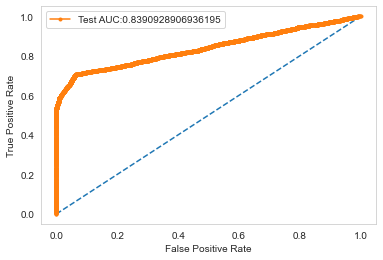

AUC for the model is: 0.8390928906936195


In [221]:
y_scores = rfclft.predict_proba(X_test)
y_scores = y_scores[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
rocauc = roc_auc_score(y_test, y_scores)
plt.plot([0,1],[0,1], linestyle='--')
plt.plot(fpr,tpr,marker='.', label='Test AUC:' + str(rocauc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.show()
print('AUC for the model is:',rocauc)

In [210]:
lr = linear_model.LogisticRegression(random_state=42, class_weight='balanced')
lr_clf = lr.fit(X_train, y_train)
cv_score = model_selection.cross_val_score(lr_clf, X_train, y_train, scoring='roc_auc', cv=5)
print('logistic regression cv avg score:', cv_score.mean())

b:\program files\phthon\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
b:\program files\phthon\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regre

logistic regression cv avg score: 0.8448590880753031


b:\program files\phthon\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [211]:
y_scores = lr.predict_proba(X_test)
y_scores = y_scores[:,1]

rocauc = roc_auc_score(y_test, y_scores)
print(rocauc)

0.8416829233023474


b:\program files\phthon\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
b:\program files\phthon\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regre

logistic regression cv avg score: 0.8448590880753031
The confusion matrix for random forest is:
 [[ 1998   832]
 [ 1860 25533]]
              precision    recall  f1-score   support

           1     0.5179    0.7060    0.5975      2830
           0     0.9684    0.9321    0.9499     27393

    accuracy                         0.9109     30223
   macro avg     0.7432    0.8191    0.7737     30223
weighted avg     0.9263    0.9109    0.9169     30223



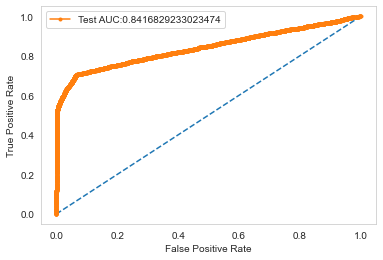

AUC for the model is: 0.8416829233023474


In [219]:
lr = linear_model.LogisticRegression(random_state=42, class_weight='balanced')
lr_clf = lr.fit(X_train, y_train)
cv_score = model_selection.cross_val_score(lr_clf, X_train, y_train, scoring='roc_auc', cv=5)
print('logistic regression cv avg score:', cv_score.mean())

y_pred2 = lr.predict(X_test)
print('The confusion matrix for random forest is:\n', confusion_matrix(y_true=y_test, y_pred=y_pred2, labels=[1, 0]))
print(classification_report(y_true=y_test, y_pred=y_pred2, labels=[1, 0], digits=4))

y_scores = lr.predict_proba(X_test)
y_scores = y_scores[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
rocauc = roc_auc_score(y_test, y_scores)
plt.plot([0,1],[0,1], linestyle='--')
plt.plot(fpr,tpr,marker='.', label='Test AUC:' + str(rocauc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.show()
print('AUC for the model is:',rocauc)

In [208]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

smt = SMOTE(random_state = 42)
X_train_smt, y_train_smt = smt.fit_sample(X_train, y_train)

y_train_smt.value_counts()

1    109568
0    109568
Name: class, dtype: int64

In [209]:
lr = linear_model.LogisticRegression(random_state=42)
lr_clf = lr.fit(X_train_smt, y_train_smt)
cv_score = model_selection.cross_val_score(lr_clf, X_train_smt, y_train_smt, scoring='roc_auc', cv=5)
print('logistic regression cv avg score:', cv_score.mean())
y_scores = lr.predict_proba(X_test)
y_scores = y_scores[:,1]
rocauc = roc_auc_score(y_test, y_scores)
print(rocauc)

b:\program files\phthon\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
b:\program files\phthon\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regre

logistic regression cv avg score: 0.9024145712694226
0.8106480157487812


b:\program files\phthon\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [213]:
lr = linear_model.LogisticRegression(random_state=42, class_weight='balanced')
lr_clf = lr.fit(X3_train, y3_train)
cv_score = model_selection.cross_val_score(lr_clf, X3_train, y3_train, scoring='roc_auc', cv=5)
print('logistic regression cv avg score:', cv_score.mean())

y_scores = lr.predict_proba(X3_test)
y_scores = y_scores[:,1]
rocauc = roc_auc_score(y3_test, y_scores)
print(rocauc)

logistic regression cv avg score: 0.8488765886531848
0.8348131741376241


In [214]:
lr = linear_model.LogisticRegression(random_state=42, class_weight='balanced')
lr_clf = lr.fit(X2_train, y2_train)
cv_score = model_selection.cross_val_score(lr_clf, X2_train, y2_train, scoring='roc_auc', cv=5)
print('logistic regression cv avg score:', cv_score.mean())

y_scores = lr.predict_proba(X2_test)
y_scores = y_scores[:,1]
rocauc = roc_auc_score(y2_test, y_scores)
print(rocauc)

b:\program files\phthon\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
b:\program files\phthon\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regre

logistic regression cv avg score: 0.8490159857543631
0.8367404416722489


b:\program files\phthon\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [215]:
smt = SMOTE(random_state = 42)
X3_train_smt, y3_train_smt = smt.fit_sample(X3_train, y3_train)

y3_train_smt.value_counts()

1    109568
0    109568
Name: class, dtype: int64

In [216]:
lr = linear_model.LogisticRegression(random_state=42, class_weight='balanced')
lr_clf = lr.fit(X3_train_smt, y3_train_smt)
cv_score = model_selection.cross_val_score(lr_clf, X3_train_smt, y3_train_smt, scoring='roc_auc', cv=5)
print('logistic regression cv avg score:', cv_score.mean())

y_scores = lr.predict_proba(X3_test)
y_scores = y_scores[:,1]
rocauc = roc_auc_score(y3_test, y_scores)
print(rocauc)

logistic regression cv avg score: 0.8498951083362142
0.8351722068223305


In [217]:
smt = SMOTE(random_state = 42)
X2_train_smt, y2_train_smt = smt.fit_sample(X2_train, y2_train)

y2_train_smt.value_counts()

1    109568
0    109568
Name: class, dtype: int64

In [218]:
lr = linear_model.LogisticRegression(random_state=42, class_weight='balanced')
lr_clf = lr.fit(X2_train_smt, y2_train_smt)
cv_score = model_selection.cross_val_score(lr_clf, X2_train_smt, y2_train_smt, scoring='roc_auc', cv=5)
print('logistic regression cv avg score:', cv_score.mean())

y_scores = lr.predict_proba(X2_test)
y_scores = y_scores[:,1]
rocauc = roc_auc_score(y2_test, y_scores)
print(rocauc)

b:\program files\phthon\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
b:\program files\phthon\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regre

logistic regression cv avg score: 0.8482774748621928
0.8377658770991894


b:\program files\phthon\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [194]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120889 entries, 51559 to 120387
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype
---  ------              --------------   -----
 0   purchase_value      120889 non-null  int64
 1   sex                 120889 non-null  int32
 2   purchase_dayofweek  120889 non-null  int64
 3   purchase_month      120889 non-null  int64
 4   device_freq         120889 non-null  int64
 5   ip_freq             120889 non-null  int64
 6   risk_country        120889 non-null  int32
 7   age_bin             120889 non-null  int32
 8   period_of_the_day   120889 non-null  int32
 9   quick_purchase      120889 non-null  int64
 10  source_Direct       120889 non-null  uint8
 11  source_SEO          120889 non-null  uint8
 12  browser_FireFox     120889 non-null  uint8
 13  browser_IE          120889 non-null  uint8
 14  browser_Opera       120889 non-null  uint8
 15  browser_Safari      120889 non-null  uint8
dtypes: int32(4), int

In [195]:
##train test data split with stratified splitting
FE3a_X = FE3_data.drop(['class'], axis=1)
FE3a_y = FE3_data['class']

Xa_train, Xa_test, ya_train, ya_test = train_test_split(FE3a_X, FE3a_y, train_size=0.8, random_state=42, stratify=FE3a_y)

In [196]:
Xa_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120889 entries, 51559 to 120387
Data columns (total 20 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   user_id             120889 non-null  int64  
 1   purchase_value      120889 non-null  int64  
 2   sex                 120889 non-null  int32  
 3   age                 120889 non-null  int64  
 4   timedif_hour        120889 non-null  float64
 5   purchase_hourofday  120889 non-null  int64  
 6   purchase_dayofweek  120889 non-null  int64  
 7   purchase_month      120889 non-null  int64  
 8   device_freq         120889 non-null  int64  
 9   ip_freq             120889 non-null  int64  
 10  risk_country        120889 non-null  int32  
 11  age_bin             120889 non-null  int32  
 12  period_of_the_day   120889 non-null  int32  
 13  quick_purchase      120889 non-null  int64  
 14  source_Direct       120889 non-null  uint8  
 15  source_SEO          120889 non

In [197]:
lr = linear_model.LogisticRegression(random_state=42)
lr_clf = lr.fit(Xa_train, ya_train)
cv_score = model_selection.cross_val_score(lr_clf, Xa_train, ya_train, scoring='roc_auc', cv=5)
print('logistic regression cv avg score:', cv_score.mean())

b:\program files\phthon\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
b:\program files\phthon\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regre

logistic regression cv avg score: 0.7687232400087576


In [204]:
lr = linear_model.LogisticRegression(random_state=42, class_weight = 'balanced')
lr_clf = lr.fit(Xa_train, ya_train)
cv_score = model_selection.cross_val_score(lr_clf, Xa_train, ya_train, scoring='roc_auc', cv=5)
print('logistic regression cv avg score:', cv_score.mean())

b:\program files\phthon\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


logistic regression cv avg score: 0.7952712636236724


In [205]:
y_scores = lr.predict_proba(Xa_test)
y_scores = y_scores[:,1]

rocauc = roc_auc_score(ya_test, y_scores)
print(rocauc)

0.7592681656697263


In [198]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

smt = SMOTE(random_state = 42)
Xa_train_smt, ya_train_smt = smt.fit_sample(Xa_train, ya_train)

ya_train_smt.value_counts()

1    109568
0    109568
Name: class, dtype: int64

In [199]:
lr = linear_model.LogisticRegression(random_state=42)
lr_clf = lr.fit(Xa_train_smt, ya_train_smt)
cv_score = model_selection.cross_val_score(lr_clf, Xa_train_smt, ya_train_smt, scoring='roc_auc', cv=5)
print('logistic regression cv avg score:', cv_score.mean())

b:\program files\phthon\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
b:\program files\phthon\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regre

logistic regression cv avg score: 0.8266014448747663


In [203]:
y_scores = lr.predict_proba(Xa_test)
y_scores = y_scores[:,1]

rocauc = roc_auc_score(ya_test, y_scores)
print(rocauc)

0.7592681656697263


### Different modeling algorithms are tuned and compared in the following 2 tables.
### ROC-AUC and weighted F1 are compared:
|                     | Default |             | Hyperparameter tuning |             |
|---------------------|---------|-------------|-----------------------|-------------|
|                     | ROC-AUC | Weighted F1 | ROC-AUC               | Weighted F1 |
| Logistic regression | 0.842   | 0.917       | N/A                   | N/A         |
| Random forest       | 0.835   | 0.947       | 0.839                 | 0.920       |
| XGBoost             | 0.839   | 0.950       | 0.836                 | 0.951       |

### Fraud precision and recall are compared:

|                     | Default         |              | Hyperparameter tuning |              |
|---------------------|-----------------|--------------|-----------------------|--------------|
|                     | Fraud precision | Fraud recall | Fraud precision       | Fraud recall |
| Logistic regression | 0.518           | 0.706        | N/A                   | N/A          |
| Random forest       | 0.928           | 0.541        | 0.534                 | 0.705        |
| XGBoost             | 0.980           | 0.537        | 0.999                 | 0.535        |

1. Based on the modeling tests, the best ROC-AUC achieved is around 0.84, and weighted F1 around 0.951.
2. The threshold could be further tuned depending on the specific business objective, either we should emphasize on the precision more or the recall.


### Modeling - feature importance

Feature rank summary from the modeling*:

* Quick_purchase
* Device_frequency
* Ip_frequency
* Purchase_month
* Source_direct
* Risk_country
* Purchase_value

\* The ranking order may not be precise


The feature importance rank based on the correlation to the dependent variable matches the observations in scatter plots:

* Quick_purchase
* Device_frequency
* Ip_frequency
* Purchase_month
* Time_difference_hour

## High-risk user characteristics
Based on what have been learned from the EDA, feature examination and modeling output. The high-risk user characteristics include:

1. Make quick purchase: less than 30s after signup.
2. Use the same device to repeat signing up and purchase.
3. Use the same IP address to repeat signing up and purchase.
4. Signup and purchase in January. (need to verify whether it’s a seasonality or a one-time characteristic)
5. Comes from direct visit.


## Model application strategy
#### We now have a model to predict the probability of first-time users committing a fraudulent activity, we may create different user experience to minimize fraudulent loss but maximize experience for normal users: 
1. If a user fraudulent probability is less than a threshold X1, the user will have normal experience; 
2. If a user fraudulent probability is larger than X1 but lower than a highly-suspicious threshold X2, the user will be asked for additional verifications; 
3. If a user fraudulent probability is larger than X2, then this user should be prohibited or at least put on hold to check his / her login data for further decision.